In [14]:
import pandas as pd
import requests
import os
from pathlib import Path
import os.path
from statsmodels.formula.api import *
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model
import numpy as np
import ast
from ast import literal_eval
from bs4 import BeautifulSoup
import matplotlib.ticker as ticker

from IPython.display import clear_output, display, HTML

In [7]:
pwd

'/home/jovyan/notebooks/achen132.github.io/src/4_analysis'

In [15]:
df = pd.read_csv('../2_clean_data/final_combine_data.csv')

In [16]:
for index, row in df.iterrows():
    df.iloc[index]['salaries'] = ast.literal_eval(df.iloc[index]['salaries'])
    df.iloc[index]['semester'] = ast.literal_eval(df.iloc[index]['semester'])
    df.iloc[index]['years_taught'] = ast.literal_eval(df.iloc[index]['years_taught'])
    df.iloc[index]['course'] = ast.literal_eval(df.iloc[index]['course'])
    df.iloc[index]['average_rating'] = np.fromstring(df.iloc[index]['average_rating'].strip("[]"), sep=',')
    df.iloc[index]['num_reviews'] = np.fromstring(df.iloc[index]['num_reviews'].strip("[]"), sep=',')
    df.iloc[index]['average_gpa'] = np.fromstring(df.iloc[index]['average_gpa'].strip("[]"), sep=',')
    df.iloc[index]['num_students'] = ast.literal_eval(df.iloc[index]['num_students'])


In [17]:
import re
df = df.drop([1615, 1616])
# Getting the minimum year
df['min_year'] = df['years_taught'].apply(lambda x: min([sem for sem in x]))
# Getting lifespan of professor from first year taught to current semester that is being taught
df['year'] = df['semester'].apply(lambda x: min([sem.split(" ")[1] for sem in x]))
df['min_year'] = df[['min_year', 'year']].min(axis=1)
df = df.drop(['year'], axis=1)
df = df.explode(['course', 'semester', 'average_rating', 'num_reviews', 'average_gpa', 'num_students'])
df['curr_year'] = df['semester'].apply(lambda x: int(x.split(" ")[1]))
df['lifetime'] = df['curr_year'] - df['min_year']
df.loc[df['lifetime'] < 0, 'lifetime'] = np.nan

/tmp/ipykernel_133/1428560398.py:7: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df['min_year'] = df[['min_year', 'year']].min(axis=1)


In [18]:
def getIndex(year, array):
    differenceArray = np.absolute(np.array(array)-year)
    return differenceArray.argmin()
def getSalary(index, salary):
    return salary[index]
df['index'] = df.apply(lambda x: getIndex(x['curr_year'], x['years_taught']), axis=1)
df['current_salary'] = df.apply(lambda x: getSalary(x['index'], x['salaries']), axis=1)
df = df.drop('index', axis=1)

In [ ]:
df['lifetime'] = df['lifetime'].astype('int')

In [7]:
df_codes = pd.read_csv('../2_clean_data/code_departments.csv')

In [20]:
df['department'] = [df_codes[df_codes['Major'].str.contains(row['course'][0:4])]['Department'].values[0] for index, row in df.iterrows()]

In [21]:
#Reset index

df.reset_index(drop=True, inplace=True)

After cleaning our data, we are ready to visualize it in a variety of graphs to find correlations between the variables that are in our dataset. This portion of the data science lifecycle is extremely important as it will lend insight into any patterns in the data and help us find outliers that may need to be removed. This will make sure we proceed with hypothesis testing and deploying our machine learning models without any preconceived assumptions. 

First, we created histograms and boxplots to view the distribution of our variables. Heavily skewed data may require that we drop or manipulate the dataset to make them more suitable for our machine learning models, and this exploration will help us determine that need.

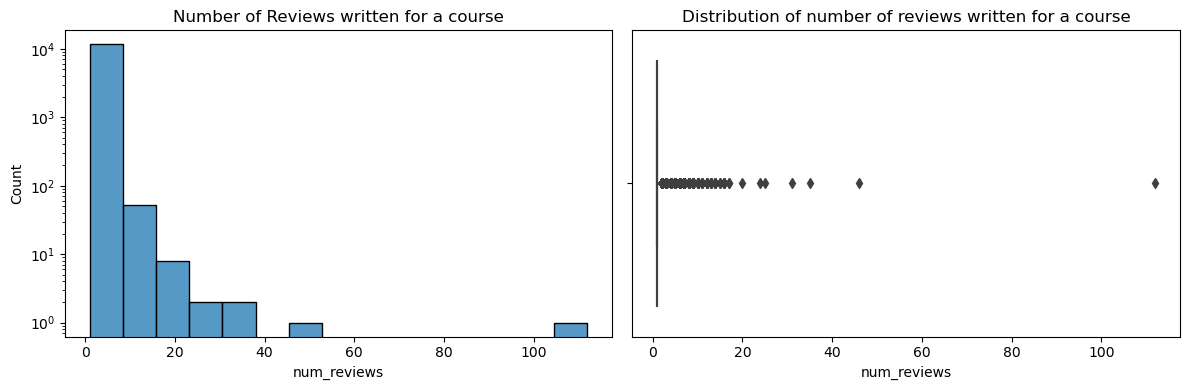

In [22]:
#Histogram distribution for number of reviews written for a course (logarithmic on y axis)

fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize=(12,4))

g = sns.histplot(data = df, x = 'num_reviews', ax = axes[0])
g.set_yscale('log')
g.set_title("Number of Reviews written for a course")

#Boxplot of distribution of number of reviews written
b = sns.boxplot(data = df, x = 'num_reviews', ax=axes[1]).set_title("Distribution of number of reviews written for a course")

fig.tight_layout()

The histogram is very positively skewed, with the majority of courses (almost 10,000) receiving less than about 5 reviews and the max being one course with over 100 reviews for the semester it was taught.

Average GPA:  3.433031475294573
Average GPA:  3.51


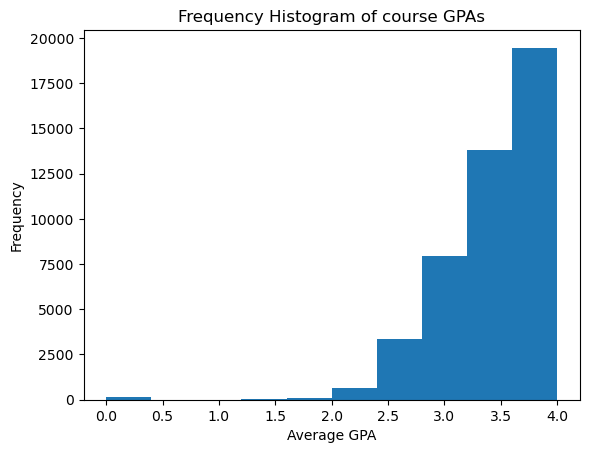

In [37]:
plt.hist(df['average_gpa'])
plt.gca().set(title='Frequency Histogram of course GPAs', ylabel='Frequency', xlabel='Average GPA');
print("Average GPA: ", df['average_gpa'].mean())
print("Average GPA: ", df['average_gpa'].median())

The distribution of GPAs across all courses taught at UMD is skewed left and not normal, as evidenced in the plot above, with the average GPA being a 3.43, or a B+.

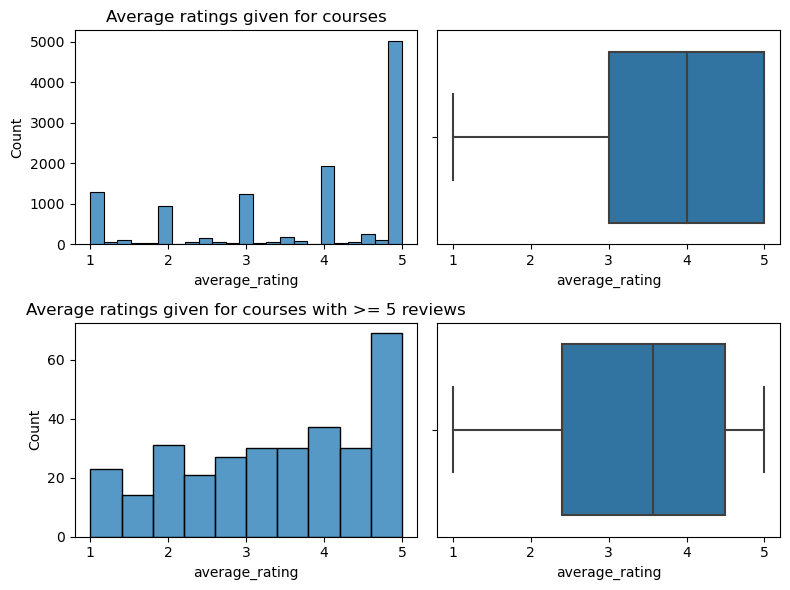

In [23]:
#Average rating plots

#Most students are given classes ratings of close to a 5/5
#Average of average rating is 4, average goes down as courses have more reviews written for it

fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize=(8,6))
numReviews = 5

sns.histplot(data = df, x='average_rating', ax = axes[0][0]).set_title("Average ratings given for courses")
sns.boxplot(data = df, x='average_rating', ax = axes[0][1])

sns.histplot(data = df[df['num_reviews'] >= numReviews], x='average_rating', ax = axes[1][0]).set_title("Average ratings given for courses with >= " + str(numReviews) + " reviews")
sns.boxplot(data = df[df['num_reviews'] >= numReviews], x='average_rating', ax = axes[1][1])

fig.tight_layout()

Most students are giving courses ratings of close to 5 (close to 5000), with the average rating given being around a 4 out of 5. There are many peaks at the whole number ratings, which makes sense given that PlanetTerp only allows for whole number ratings to be given for a course, and the majority of our data consists of courses with fewer than 5 reviews, making it likely that the average is close to a whole number. In fact, if we only plot rating data for courses with more than 5 reviews, these peaks flatten out.

Next, we made a PairPlot between our variables to get a birds-eye view of the relationships between average rating, average gpa, the number of years a professor has taught, the professor's salary, and the number of students in a course.

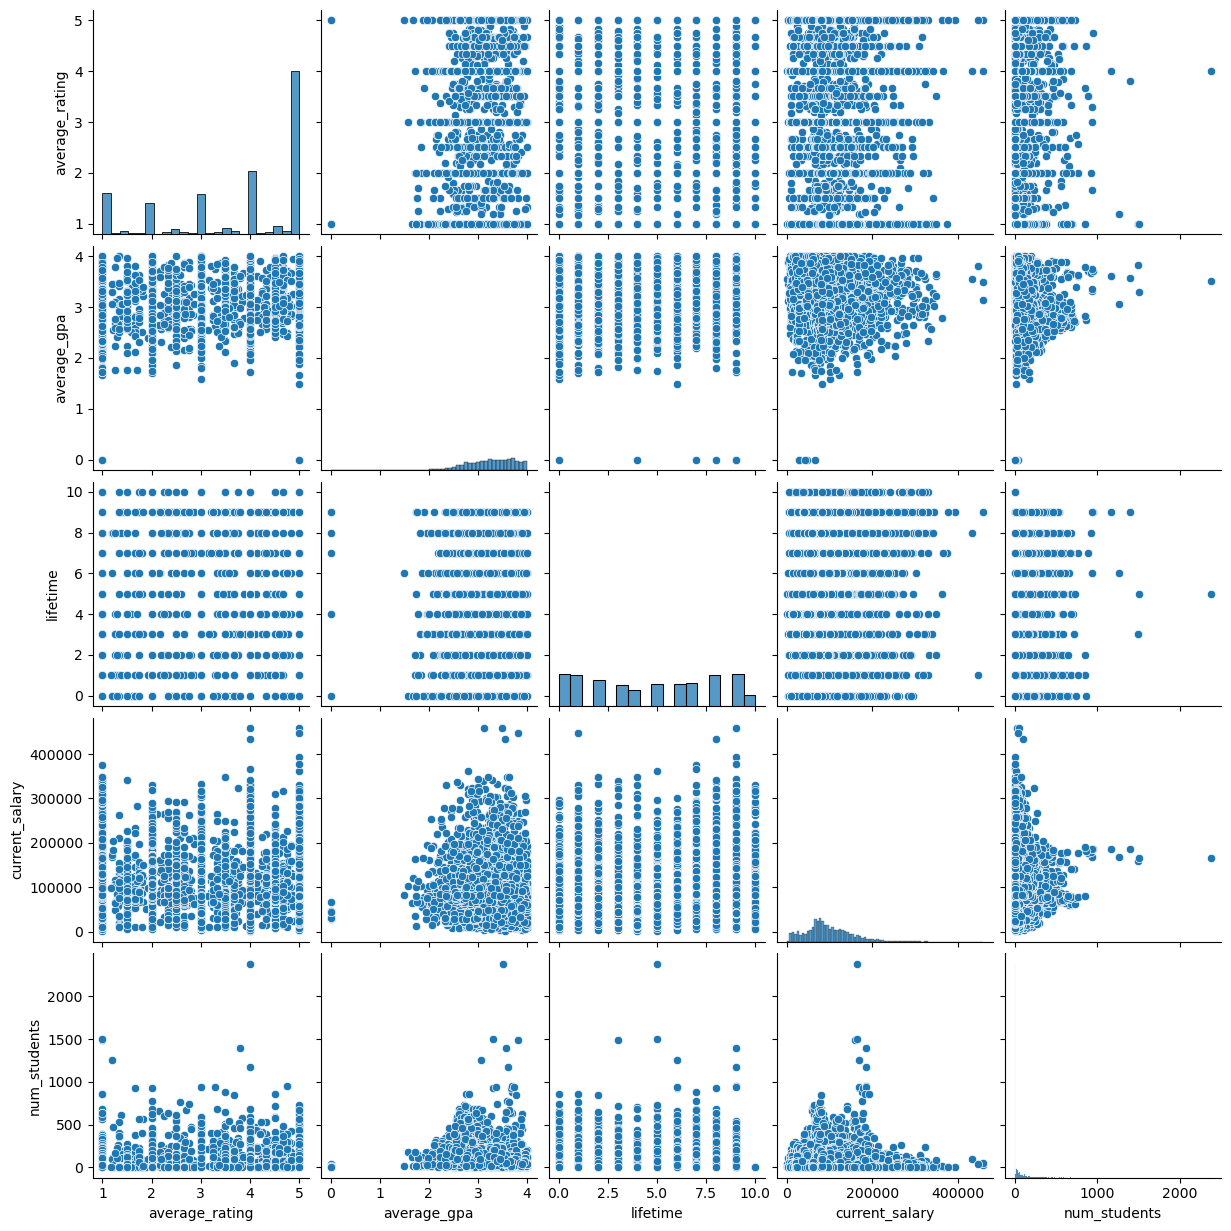

In [24]:
df_test = df[(df['num_reviews'] >= 0)]

g = sns.pairplot(df_test[["average_rating", "average_gpa", "lifetime", "current_salary", "num_students"]])

Each axis contains the five variables we want to find relationships between, and each plot is a scatterplot between two variables given by the x and y axis. Along the diagonal of the PairPlot, a histogram of the counts of each variable is shown.

There is a slight positive correlation between average rating and average_gpa, corroborating the finding from the previous section where we found the same relationship. Another thing we see from the graph above is that there is a positive correlation between lifetime (number of years that a professor has taught) and their salary, as professors who have taught below 3 years never have a salary higher than about $200,000. 

To further explore the correlation between lifetime, salary, and average rating of a professor, we made a scatterplot focusing on just those variables. 

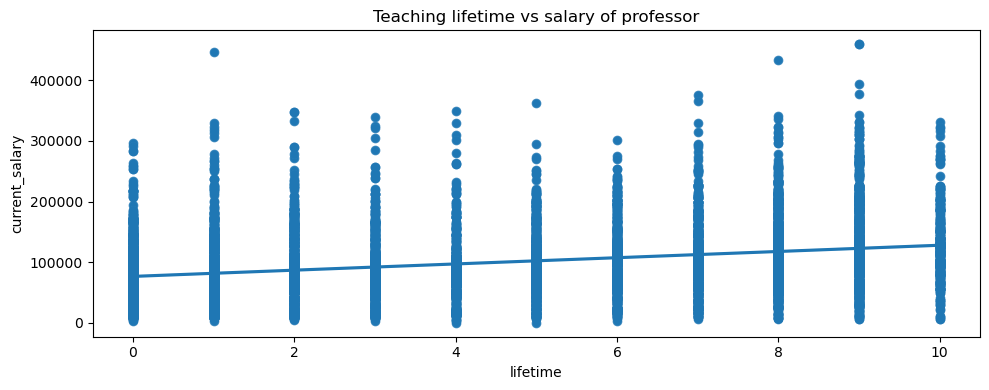

In [25]:
#Relationship between lifetime and salary

fig, axes = plt.subplots(figsize=(10,4))

numReviews = 0

sns.scatterplot(data=df[df['num_reviews'] >= 0], x='lifetime', y='current_salary', ax = axes).set_title("Teaching lifetime vs salary of professor")
sns.regplot(data=df[df['num_reviews'] >= 0], x='lifetime', y='current_salary', ax = axes)
fig.tight_layout()

We see that there is a positive correlation between the number of years a professor has taught and their current salary. This intuitively makes sense from the viewpoint of the administration at UMD, because the university would generally want to reward professors with more experience with a higher salary. Also, there may be automatic salary bumps at the end of each year that leads to this relationship.

To further explore the relationship that a professsor's teaching time at UMD is compared to their performance, we plotted the difference in average rating and GPA across courses taught by professors with different years of teaching experience.

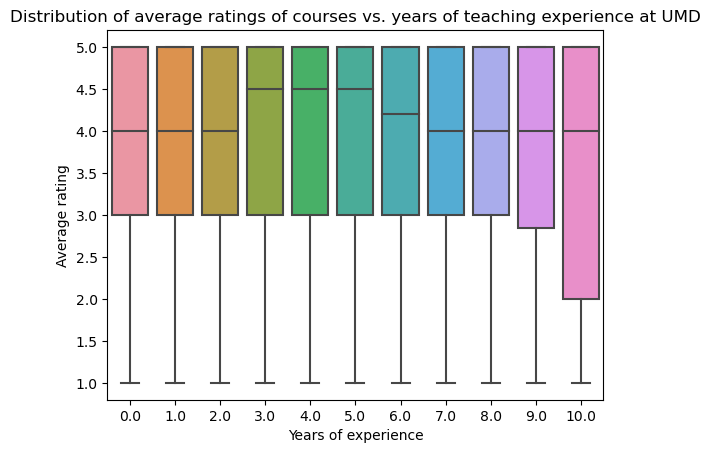

In [32]:
fig, ax = plt.subplots()
rating = {}

for years_taught in sorted(df[df['lifetime'].notna()]['lifetime'].unique()):
    df_years_taught = df[(df['lifetime'] == years_taught) & (df['num_students'].notna())]
    rating[years_taught] = df_years_taught['average_rating']    

df_ratings = pd.DataFrame.from_dict(rating)
s = sns.boxplot(data=df_ratings)
s.set(title="Distribution of average ratings of courses vs. years of teaching experience at UMD", xlabel='Years of experience', ylabel='Average rating')
#sns.lineplot(x=np.arange(0,10), y=median_gpas, c='red', linewidth=3)

plt.show()

There isn't a general upward trend in the means of the average rating as a professor gets more experienced - as it hovers around a 4 to a 4.5 across all years - but we do see that past 7 years of experience, the interquartile range gets wider, meaning teachers with high experience are getting many lower than average ratings. 

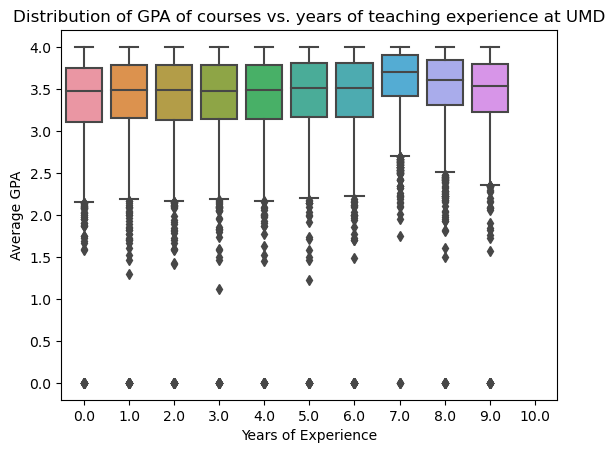

In [44]:
#GPA of courses taught by professors with different years of teaching experience
fig, ax = plt.subplots()
gpa = {}
median_gpas = []

for years_taught in sorted(df[df['lifetime'].notna()]['lifetime'].unique()):
    df_years_taught = df[(df['lifetime'] == years_taught) & (df['average_gpa'].notna())]
    gpa[years_taught] = df_years_taught['average_gpa']
    median_gpas.append(df_years_taught['average_gpa'].median())
    

df_gpa = pd.DataFrame.from_dict(gpa)
s = sns.boxplot(data=df_gpa)
s.set(title="Distribution of GPA of courses vs. years of teaching experience at UMD", xlabel='Years of Experience', ylabel='Average GPA')

plt.show()

However, there does not appear to be a correlation between the average GPA of a course and the years of experience the professor teaching that course has. Except for a professor with 7 years of experience, the average GPA is slightly 

TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

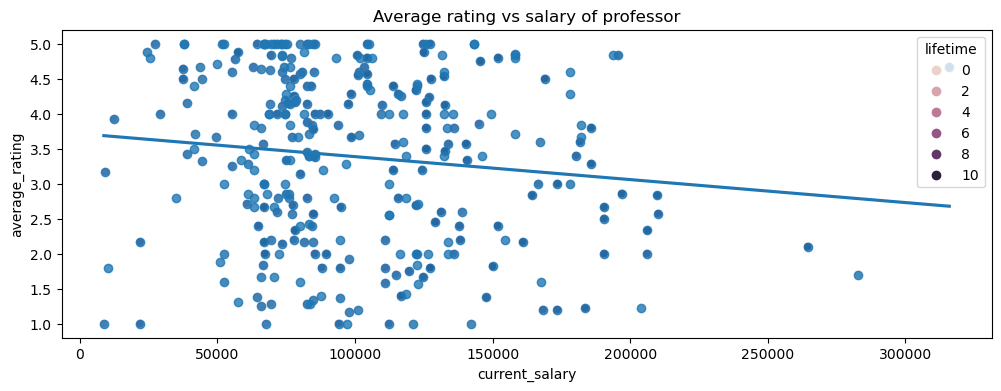

In [26]:
#Relationship between salary and average rating with hue of teaching_duration_as_of_course 
#Professors with a lower teaching experience at UMD tend to have a lower salary

fig, axes = plt.subplots(figsize=(12,4))

numReviews = 5

sns.scatterplot(data=df[df['num_reviews'] >= numReviews], x='current_salary', y='average_rating', hue='lifetime', ax = axes).set_title("Average rating vs salary of professor")
sns.regplot(data=df[df['num_reviews'] >= numReviews], x='current_salary', y='average_rating', ax = axes)

axes[0].xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'${x/1000:.0f}k'))
axes[1].xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'${x/1000:.0f}k'))

fig.tight_layout()

There may be a difference in the average GPA and average rating given the department the course was a part of. We explored this below.

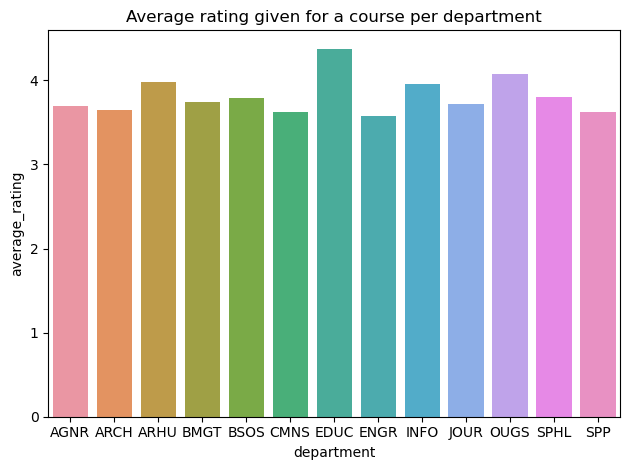

In [33]:
#Average rating given in each department

s = sns.barplot(data = df.groupby('department')['average_rating'].mean().reset_index(), x = 'department', y='average_rating')
s.set(title="Average rating given for a course per department")
plt.tight_layout()

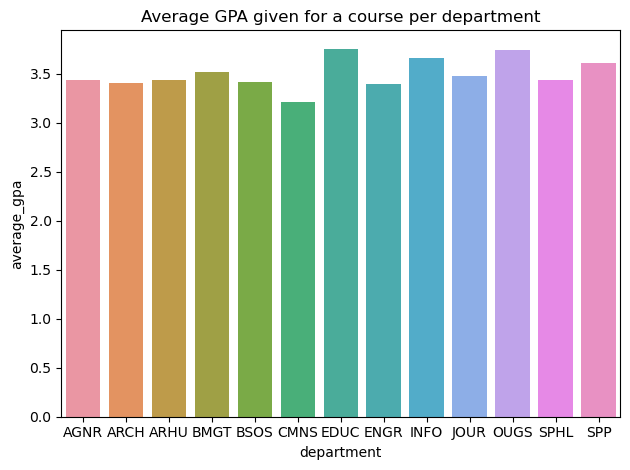

In [39]:
#Average rating given in each department

s = sns.barplot(data = df.groupby('department')['average_gpa'].mean().reset_index(), x = 'department', y='average_gpa')
s.set(title="Average GPA given for a course per department")
plt.tight_layout()

Courses taught in the College of Education (EDUC) and Office of Undergraduate Studies (OUGS) appear to have both the highest average ratings and average GPAs among the departments. These departments having both the highest average rating and GPA further reinforces a trend that we are seeing among our data; that if professor's ratings are higher, their average course GPA tends to be higher as well. 